In [1]:
# Install Kaggle
!pip install kaggle

# Create a Kaggle directory and upload kaggle.json
import os
from google.colab import files

# Create a Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Upload kaggle.json
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Move kaggle.json to the directory
for filename in uploaded.keys():
    os.rename(filename, "/root/.kaggle/kaggle.json")

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

# Download a Kaggle dataset (replace 'dataset-owner/dataset-name' with your dataset)
!kaggle datasets download -d jangedoo/utkface-new


Please upload your kaggle.json file


Saving kaggle (1).json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 97% 321M/331M [00:03<00:00, 127MB/s]
100% 331M/331M [00:03<00:00, 113MB/s]


In [2]:
# Unzip the dataset
import zipfile

# Replace 'dataset-name.zip' with the downloaded file name
with zipfile.ZipFile("utkface-new.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

print("Dataset downloaded and unzipped successfully!")

Dataset downloaded and unzipped successfully!


In [35]:
import os
from re import I
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [4]:
print(len(os.listdir("/content/UTKFace")))
print(len(os.listdir("/content/crop_part1")))

23708
9780


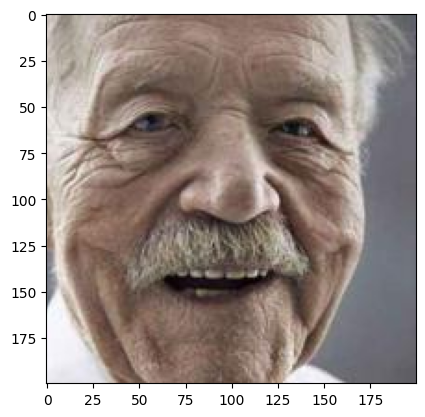

In [36]:
img_path = "/content/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()

In [5]:
age=[]
gender=[]
ethinicity=[]
path=[]

for i in os.listdir("/content/UTKFace"):
  path.append(i)
  age.append(int(i.split("_")[0]))
  gender.append(int(i.split("_")[1]))

  try:
    ethnicity_value = int(i.split("_")[2])
  except ValueError:
      ethnicity_value = 0

  if ethnicity_value == 0:
      ethinicity.append(0)
  elif ethnicity_value == 1:
      ethinicity.append(1)
  elif ethnicity_value == 2:
      ethinicity.append(2)
  else:
      ethinicity.append(3)


In [6]:
len(path),len(age),len(gender),len(ethinicity)

(23708, 23708, 23708, 23708)

Text(0, 0.5, 'Count')

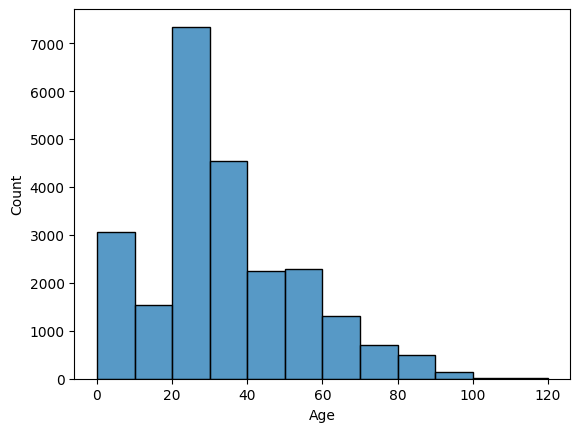

In [7]:
sns.histplot(age,bins=[0,10,20,30,40,50,60,70,80,90,100.110,120])
plt.xlabel("Age")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

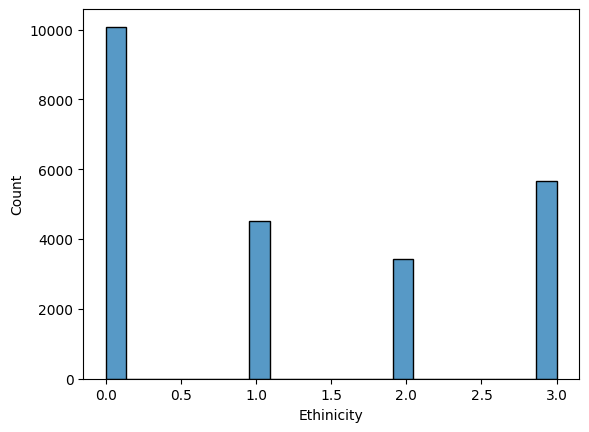

In [8]:
sns.histplot(ethinicity)
plt.yticks()
plt.xlabel("Ethinicity")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

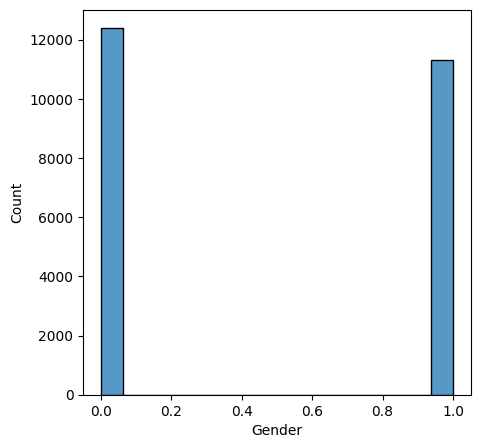

In [9]:

plt.figure(figsize=(5,5))
sns.histplot(gender)
plt.xlabel("Gender")
plt.ylabel("Count")

In [10]:
arr = np.array(age)
age_series = pd.Series(arr)
age_series.quantile(0.25)

23.0

In [11]:
gender = np.array(gender)
gender_series = pd.Series(gender)
gender_series.value_counts()

,count
0,12391
1,11317


In [12]:
#Removing the outliers and fill with mean values
def remove_outliers(feature):
        Q1 = feature.quantile(0.25)
        Q3 = feature.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        feature = feature.where(
            ~( (feature < lower_bound) | (feature > upper_bound) ),
            other=int(feature.mean())
          )

        return feature

<Axes: >

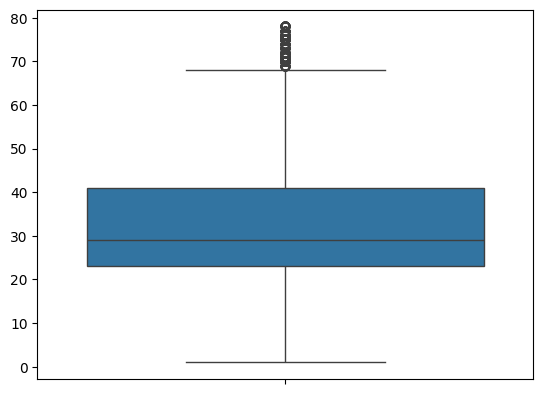

In [13]:
age_ro = remove_outliers(age_series)
sns.boxplot(age_ro)

<Axes: >

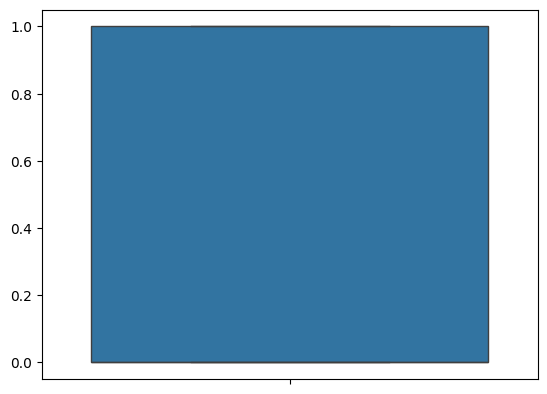

In [14]:
gender_ro = remove_outliers(gender_series)
sns.boxplot(gender_ro)

<Axes: >

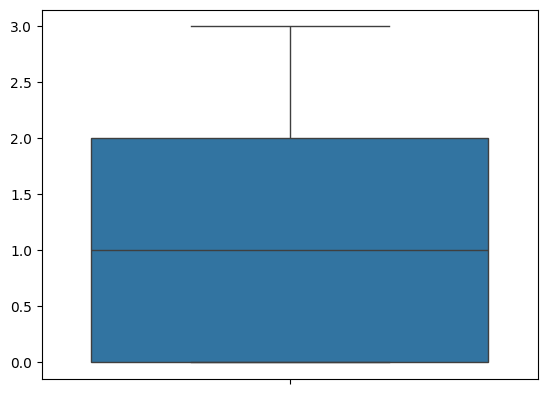

In [15]:
arr = np.array(ethinicity)
ethinicity = pd.Series(arr)
ethinicity_ro = remove_outliers(ethinicity)
sns.boxplot(ethinicity_ro)

In [16]:
df=pd.DataFrame({"path":path,"age":age_ro,"gender":gender_ro,"ethinicity":ethinicity_ro})
df.head()

,path,age,gender,ethinicity
0,28_1_0_20170105183923408.jpg.chip.jpg,28,1,0
1,26_1_0_20170113210127505.jpg.chip.jpg,26,1,0
2,16_1_4_20170103201023166.jpg.chip.jpg,16,1,3
3,2_0_4_20161221195201991.jpg.chip.jpg,2,0,3
4,35_0_1_20170117121610224.jpg.chip.jpg,35,0,1


In [19]:
len(df["age"]),len(df["gender"]),len(df['ethinicity'])

(23708, 23708, 23708)

In [20]:
train_df=df.sample(frac=1,random_state=4)[:20000]
test_df=df.sample(frac=1,random_state=2)[20000:]

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


In [22]:
from ctypes import resize
train_gen=ImageDataGenerator(rescale=1./255,
                             rotation_range=30,
                             width_shift_range=0.0, height_shift_range=0.0)

test_gen=ImageDataGenerator(rescale=1./255)

In [23]:
train_ds=train_gen.flow_from_dataframe(dataframe=train_df,directory="/content/UTKFace",x_col="path",y_col=["age","gender","ethinicity"],target_size=(200,200),batch_size=32,class_mode="raw")
test_ds=test_gen.flow_from_dataframe(dataframe=test_df,directory="/content/UTKFace",x_col="path",y_col=["age","gender","ethinicity"],target_size=(200,200),batch_size=32,class_mode="raw")

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [24]:
from tensorflow.keras.applications import xception
from PIL import Image

In [25]:
con_base=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(200,200,3),
    classes=1000,
    classifier_activation="softmax",
    name="xception",
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
from keras.models import Model
from keras.layers import *

In [27]:
output=con_base.layers[-1].output
flatten=Flatten()(output)
dense1_1=Dense(512,activation="relu")(flatten)
dense1_2=Dense(256,activation="relu")(flatten)
dense1_3=Dense(256,activation="relu")(flatten)

norm_1=BatchNormalization()(dense1_1)
norm_2=BatchNormalization()(dense1_2)
norm_3=BatchNormalization()(dense1_3)

dense1_10=Dense(256,activation="relu")(norm_1)
dense1_20=Dense(128,activation="relu")(norm_2)
dense1_30=Dense(128,activation="relu")(norm_3)

norm_10=BatchNormalization()(dense1_10)
norm_20=BatchNormalization()(dense1_20)
norm_30=BatchNormalization()(dense1_30)

dense2_1=Dense(128,activation="relu")(norm_10)
dense2_2=Dense(64,activation="relu")(norm_20)
dense2_3=Dense(64,activation="relu")(norm_30)

#drop_1=Dropout(0.5)(dense2_1)
drop_2=Dropout(0.5)(dense2_2)
drop_3=Dropout(0.5)(dense2_3)

dense3=Dense(64,activation="relu")(dense2_1)
dense4=Dense(32,activation="relu")(dense3)

output_1=Dense(1,activation='linear',name="age")(dense4)
output_2=Dense(1,activation='sigmoid',name="gender")(drop_2)
output_3=Dense(4,activation='softmax',name="ethinicity")(drop_3)

In [28]:
Model=Model(inputs=con_base.input,outputs=[output_1,output_2,output_3])

In [29]:
Model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 99, 99, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 99, 99, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 99, 99, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 97, 97, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 97, 97, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 97, 97, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 97, 97, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 97, 97, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 97, 97, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 97, 97, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 97, 97, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 49, 49, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 49, 49, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 123,886,318 (472.59 MB)

 Trainable params: 123,828,718 (472.37 MB)

 Non-trainable params: 57,600 (225.00 KB)

In [30]:
Model.compile(optimizer="adam",
              loss={"age":"mse","gender":"binary_crossentropy","ethinicity":"sparse_categorical_crossentropy"},
              metrics={"age":"mae","gender":"accuracy","ethinicity":"accuracy"})

In [31]:
Model.fit(train_ds,epochs=5,validation_data=test_ds,batch_size=32)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 379s 500ms/step - age_mae: 13.6336 - loss: 310.4148 - val_age_mae: 14.5869 - val_loss: 297.4717
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 336s 483ms/step - age_mae: 13.7494 - loss: 291.2539 - val_age_mae: 13.8167 - val_loss: 294.1093
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 319s 480ms/step - age_mae: 13.7481 - loss: 290.6221 - val_age_mae: 13.6945 - val_loss: 290.6676
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 330s 491ms/step - age_mae: 13.7694 - loss: 289.7316 - val_age_mae: 13.5222 - val_loss: 291.7426
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 481ms/step - age_mae: 13.7451 - loss: 289.6920 - val_age_mae: 13.5686 - val_loss: 292.4180


In [49]:
# PREDICTIVE SYSTEM
def predict(path):
  img = Image.open(path)
  img = img.resize((200,200))
  img = img.convert('RGB')
  img = np.array(img)
  img = img/255
  img = img.reshape(1,200,200,3)
  pred = Model.predict(img)
  age = pred[0]
  if pred[1] < 0.5:
    gender = 'Male'
  else:
    gender = 'Female'
  if np.argmax(pred[2]) == 0:
    eth = 'Black'
  elif np.argmax(pred[2]) == 1:
    eth = 'White'
  elif np.argmax(pred[2]) == 2:
    eth = 'Asian'
  else:
    eth = 'others'
  return age , gender , eth

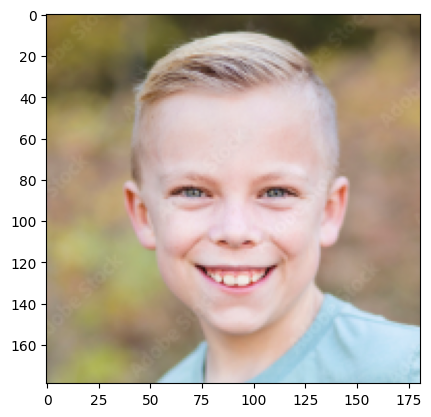

In [50]:
img_path ="/content/Screenshot 2025-01-18 215230.png"
img = mpimg.imread(img_path)
plt.imshow(img)

In [51]:
predict(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


(array([[6.320128]], dtype=float32), 'Male', 'White')